<a href="https://colab.research.google.com/github/wlvvs/FY22-Q2-AI-Hackathon-Anomaly-Detection/blob/master/notebooks/AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FY22-Q2-AI-Hackathon-Anomaly-Detection

### Proposed Topic: Early detection of documents having increased chances of publishing error.

**ABCD (Application Bundle for Creating Documents)** is a mission critical client application accessed by large number of users from Legal and Pricing team. 
One of the primary app function is to publish new custom document packages from multiple document templates and rate tables. Publishing this document packages in a timely fashion is critical for client business. All documents are expected to be Auto Published. Any major delays will invite penalties and sanctions from government entities.
A document is considered Auto Published if it gets successfully published the same day or next day. If the document do not get Auto Published, it will require manual intervention. The investigation will be done by a technical team and the document republished using an alternate manual process at the earliest. 

### Current Approach
* Client has tasked Accenture to help increase Auto Publish % and thus reduce the risk of inviting penalties. 
* The team is expected to identify and resolve issues within 24 hours. 
* Have implemented Database Alerting. Technical team will receive alerts once the issue happens (Auto Publish Indicator = N). 

### Problem Statements
* Current approach of detecting issue and republishing manually is reactive in nature. 
* The team comes to know about the issue only after it happens. A delay of 24 to 47 hours before the issue is identified.
* Bare minimal time for correction and republishing. Tight SLA - team under pressure to fix the issue within 24 hours. 
* Higher risk of missing SLAs - for both Accenture Technical teams and Client.
* 24x7 support from technical teams required, thus increasing cost.

### Proposed Solution
* Attempt to create a ML based Anomaly detection model which has the ability to predict with certain confidence the document packages that has increased chances of failing Auto Publishing.

### Benefits
* Technical team will be alerted on document packages having increased chances of failing Auto Publish, at the time of Approval.
* Technical team can monitor risky packages closely and line up resources accordingly.
* Can educate client if patterns of incorrect usage identified.
* Staffing support team as needed based on census and recommendations received. Reduced cost for Accenture.
* Reduced risk of penalties. Increased Customer Satisfaction.

#### Notes:
🧑 Auto Publish indicator is set as Y when the difference of Package Published Date and Package Approved Date equals 0 or 1. It will be N otherwise.

🧑 A blank value in Package Published Date will indicate the document package is not yet published. It can be treated as Not Auto Published.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

Dentro del repositorio de Github en donde se inició el proyecto, está el dataset base para el desarrollo del análisis de información. Contiene un layout de datos generales asociando los documentos y el proceso de creación y validación para su publicación automática de manera genérica.
La carga de información para comenzar el procesamiento se plantea por el consumo de un archivo .csv crudo, en donde la información no ha sido configurada para formar parte de un dataset.

In [ ]:
url = 'https://raw.githubusercontent.com/wlvvs/FY22-Q2-AI-Hackathon-Anomaly-Detection/master/data/raw/ABCDPublishingStatistics2017-2022_Master.csv'

Para que dicho dataset pueda ser operado dentro del modelo a construir, se necesita generar un dataframe, que es una estructura de datos usada por la librería de pandas, a fin de poder manipular y operar con la información.
Dentro del .csv se encuentran varios datos identificados como valores de fecha y hora, datos numéricos y cadenas de carácteres.

Para aprovechar las herramientas de pandas al momento de generar el dataframe, se realizará la construcción del mismo mapeando campos específicos que se tienen identificados como fechas que, además, serán utilizados posteriormente.

En la siguiente tabla, dentro de la columna de valores que se incluirán en entrenamiento, se marcan aquellas que dan valor con respecto a verificación inicial de los datos, así como las hallazgos generales al momento de analizar la información por medio de funciones embebidas dentro de un editor de hojas de cálculo

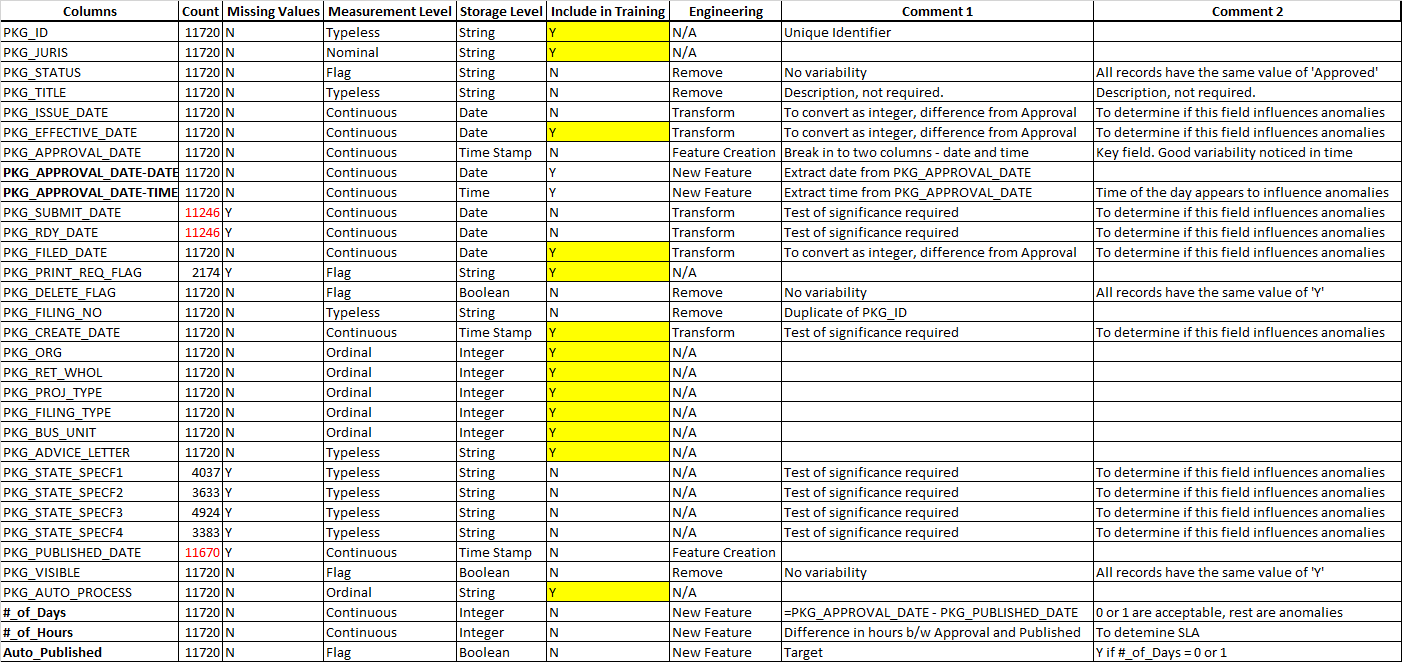

El archivo .csv consta de 11720 registros, separados por un pipe (|). De los datos marcados como necesarios para el modelo, existen algunos que corresponden a valores de fecha.
Por principio, es la información que se requiere de primera mano para generar el dataframe.

In [ ]:
df = pd.read_csv(url,sep ='|',
                 parse_dates = ['PKG_EFFECTIVE_DATE', 'PKG_APPROVAL_DATE', 'PKG_FILED_DATE','PKG_CREATE_DATE', 'PKG_PUBLISHED_DATE'])

Una vez que la información del .csv se convierte en dataframe, luce de la siguiente manera:


In [ ]:
df.sample(5)

,PKG_ID,PKG_JURIS,PKG_STATUS,PKG_TITLE,PKG_ISSUE_DATE,PKG_EFFECTIVE_DATE,PKG_APPROVAL_DATE,PKG_SUBMIT_DATE,PKG_RDY_DATE,PKG_FILED_DATE,PKG_PRINT_REQ_FLAG,PKG_DELETE_FLAG,PKG_FILING_NO,PKG_CREATE_DATE,PKG_ORG,PKG_RET_WHOL,PKG_PROJ_TYPE,PKG_FILING_TYPE,PKG_BUS_UNIT,PKG_ADVICE_LETTER,PKG_STATE_SPECF1,PKG_STATE_SPECF2,PKG_STATE_SPECF3,PKG_STATE_SPECF4,PKG_PUBLISHED_DATE,PKG_VISIBLE,PKG_AUTO_PROCESS
1359,NC-17-0039,NORTH CAROLINA,Approved,Business Local Service Increase,01/06/2017 00:00,2017-01-06,2017-01-06 13:01:00,18/05/2017 05:38,18/05/2017 11:01,2017-01-06 13:01:00,D,Y,NC-17-0039,2017-03-29 10:15:00,1,1,12,2,9,0,NaN,NaN,NaN,NaN,2017-01-06 13:49:00,Y,Z
1997,LA-17-0004,LOUISIANA,Approved,August 2017 Publication Changes,12/08/2017 00:00,2017-12-08,2017-12-08 07:00:00,26/07/2017 12:30,26/07/2017 12:30,2017-07-26 12:30:00,NaN,Y,LA-17-0004,2017-07-17 14:55:00,1024,1,17,10,2,0,201788,NaN,NaN,NaN,2017-12-08 07:53:00,Y,N
11024,NV-21-0028,NEVADA,Approved,Business MTS Two Point Service (Toll) Reprice,28/09/2021 00:00,2021-09-28,2021-09-28 06:30:00,15/06/2021 09:58,15/06/2021 14:30,2021-07-22 20:33:00,NaN,Y,NV-21-0028,2021-06-14 15:58:00,8,1,12,10,33,0,NaN,NaN,NaN,NaN,2021-05-10 12:29:00,Y,N
5985,SC-19-0017,SOUTH CAROLINA,Approved,Business Analog Private Line Increases,01/03/2019 00:00,2019-01-03,2019-01-03 08:30:00,03/01/2019 12:35,08/01/2019 14:55,2019-02-19 08:00:00,D,Y,SC-19-0017,2019-03-01 11:37:00,1,1,12,10,33,0,NaN,NaN,NaN,NaN,2019-02-03 13:15:00,Y,Z
1062,N4-17-0603,NEW JERSEY,Approved,Prime Standalone Changes,30/04/2017 00:00,2017-04-30,2017-04-30 06:30:00,11/04/2017 10:01,11/04/2017 10:22,2017-04-28 09:04:00,NaN,Y,N4-17-0603,2017-03-29 13:35:00,256,1,17,14,16,0,Y~,REM,201753,TLX,2017-04-30 07:33:00,Y,N


Cuando revisamos las caracteristicas de los campos asociados al dataframe, se nota que aquellos que fueron elegidos dentro del proceso de creación para ser considerados como campos de tipo de tiempo, ya aparecen con dicha configuración establecida en origen.
Esto es importante porque si bien los campos de fecha con tiempo son utiles per se, estos brindan mas información que puede ser descompuesta o extraida para ser usada con fines especificos en el modelo

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11719 entries, 0 to 11718
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   PKG_ID              11719 non-null  object        
 1   PKG_JURIS           11719 non-null  object        
 2   PKG_STATUS          11719 non-null  object        
 3   PKG_TITLE           11719 non-null  object        
 4   PKG_ISSUE_DATE      11719 non-null  object        
 5   PKG_EFFECTIVE_DATE  11719 non-null  datetime64[ns]
 6   PKG_APPROVAL_DATE   11719 non-null  datetime64[ns]
 7   PKG_SUBMIT_DATE     11245 non-null  object        
 8   PKG_RDY_DATE        11245 non-null  object        
 9   PKG_FILED_DATE      11719 non-null  datetime64[ns]
 10  PKG_PRINT_REQ_FLAG  2173 non-null   object        
 11  PKG_DELETE_FLAG     11719 non-null  object        
 12  PKG_FILING_NO       11719 non-null  object        
 13  PKG_CREATE_DATE     11719 non-null  datetime64

Regresando a la imagen de la hoja de cálculo en donde se muestran las inferencias iniciales, las columnas que toman relevancia seran separadas de la muestra total del dataframe, con el fin de hacer la carga de datos mas pequeña y que esta contenga el universo contemplado dentro del proceso de análisis.
Con lo anterior, el dataframe quedó reducido a 14 columnas, considerando los 11719 registros de la muestra inicial.

In [ ]:
df = df[['PKG_ID', 'PKG_JURIS', 'PKG_EFFECTIVE_DATE', 'PKG_APPROVAL_DATE',
         'PKG_FILED_DATE','PKG_CREATE_DATE', 'PKG_ORG', 'PKG_RET_WHOL',
         'PKG_PROJ_TYPE', 'PKG_FILING_TYPE', 'PKG_BUS_UNIT', 'PKG_ADVICE_LETTER',
         'PKG_PUBLISHED_DATE', 'PKG_AUTO_PROCESS']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11719 entries, 0 to 11718
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   PKG_ID              11719 non-null  object        
 1   PKG_JURIS           11719 non-null  object        
 2   PKG_EFFECTIVE_DATE  11719 non-null  datetime64[ns]
 3   PKG_APPROVAL_DATE   11719 non-null  datetime64[ns]
 4   PKG_FILED_DATE      11719 non-null  datetime64[ns]
 5   PKG_CREATE_DATE     11719 non-null  datetime64[ns]
 6   PKG_ORG             11719 non-null  int64         
 7   PKG_RET_WHOL        11719 non-null  int64         
 8   PKG_PROJ_TYPE       11719 non-null  int64         
 9   PKG_FILING_TYPE     11719 non-null  int64         
 10  PKG_BUS_UNIT        11719 non-null  int64         
 11  PKG_ADVICE_LETTER   11719 non-null  int64         
 12  PKG_PUBLISHED_DATE  11669 non-null  datetime64[ns]
 13  PKG_AUTO_PROCESS    11719 non-null  object    

El siguiente paso dentro del proceso de limpieza de datos, es verificar que las columnas que se eligieron para formar parte del proceso contienen valores. Esta verificación se hizo de igual forma como parte del analisis inicial de datos, sin embargo, con la segmentación de información, los valores en afectación puede que hayan incrementado o disminuido.

Es importante realizar este proceso de limpieza ya que la información faltante puede representar en desviaciones o variaciones de resultados al momento de plantear el entrenamiento y modelo de datos.



In [ ]:
df.isna().sum()

PKG_ID                 0
PKG_JURIS              0
PKG_EFFECTIVE_DATE     0
PKG_APPROVAL_DATE      0
PKG_FILED_DATE         0
PKG_CREATE_DATE        0
PKG_ORG                0
PKG_RET_WHOL           0
PKG_PROJ_TYPE          0
PKG_FILING_TYPE        0
PKG_BUS_UNIT           0
PKG_ADVICE_LETTER      0
PKG_PUBLISHED_DATE    50
PKG_AUTO_PROCESS       0
dtype: int64

Los datos que aparecen como nulos para la columna PKG_PUBLISHED_DATE corresponden a documentos que aun no han sido publicados.
Partiendo de los estatutos del problema a resolver, esta información no es necesaria dentro del universo del modelo debido a que aún no muestra el valor base para identificar si el archivo puede o no tener anomalias.
Esa es la razón por la cual se pueden discriminar dichos registros y, con ello, ayudar al proceso de entrenamiento y mejorar los porcentajes de efectividad del mismo.

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

PKG_ID                0
PKG_JURIS             0
PKG_EFFECTIVE_DATE    0
PKG_APPROVAL_DATE     0
PKG_FILED_DATE        0
PKG_CREATE_DATE       0
PKG_ORG               0
PKG_RET_WHOL          0
PKG_PROJ_TYPE         0
PKG_FILING_TYPE       0
PKG_BUS_UNIT          0
PKG_ADVICE_LETTER     0
PKG_PUBLISHED_DATE    0
PKG_AUTO_PROCESS      0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11669 entries, 0 to 11718
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   PKG_ID              11669 non-null  object        
 1   PKG_JURIS           11669 non-null  object        
 2   PKG_EFFECTIVE_DATE  11669 non-null  datetime64[ns]
 3   PKG_APPROVAL_DATE   11669 non-null  datetime64[ns]
 4   PKG_FILED_DATE      11669 non-null  datetime64[ns]
 5   PKG_CREATE_DATE     11669 non-null  datetime64[ns]
 6   PKG_ORG             11669 non-null  int64         
 7   PKG_RET_WHOL        11669 non-null  int64         
 8   PKG_PROJ_TYPE       11669 non-null  int64         
 9   PKG_FILING_TYPE     11669 non-null  int64         
 10  PKG_BUS_UNIT        11669 non-null  int64         
 11  PKG_ADVICE_LETTER   11669 non-null  int64         
 12  PKG_PUBLISHED_DATE  11669 non-null  datetime64[ns]
 13  PKG_AUTO_PROCESS    11669 non-null  object    

Con respecto a la primera fase de análisis, es claro que el tiempo que pasa entre el momento en que se aprueba la publicación de un archivo y el momento en que se publica corresponde al centro funcional del proceso, es decir, que dicho valor es primordial para la definición de anomalías, sin embargo, no se encuentra dentro de las columnas que ofrece el dataset en su etapa inicial.

Tanto la columna de número de días (#Days) como el número de horas (#Hours) forman parte de directrices que pueden cambiar la perspectiva del comportamiento de los datos, por ello, estas columnas son agregadas al dataframe general en donde se realizará la predicción.

De igual forma, se identifica como anomalía en el proceso que las publicaciones excedan en un día con respecto al momento de aprobación y la publicación per se, por lo que es sumamente importante encontrar al correlación que existe entre los diferentes campos que condicionan la publicación automatica del archivo con los tiempos de ejecución de las tareas.

In [ ]:
df['#DAYS'] = df['PKG_PUBLISHED_DATE'] - df['PKG_APPROVAL_DATE']
df['#DAYS'] = df['#DAYS']/np.timedelta64(1,'D')
df.sample(5)

,PKG_ID,PKG_JURIS,PKG_EFFECTIVE_DATE,PKG_APPROVAL_DATE,PKG_FILED_DATE,PKG_CREATE_DATE,PKG_ORG,PKG_RET_WHOL,PKG_PROJ_TYPE,PKG_FILING_TYPE,PKG_BUS_UNIT,PKG_ADVICE_LETTER,PKG_PUBLISHED_DATE,PKG_AUTO_PROCESS,#DAYS
6245,NC-19-0022,NORTH CAROLINA,2019-03-04,2019-03-04 09:54:00,2019-03-21 08:37:00,2019-08-02 14:47:00,1,1,12,10,33,0,2019-03-04 10:51:00,Z,0.039583
7455,NV-19-0036,NEVADA,2019-01-11,2019-01-11 06:30:00,2019-10-10 13:43:00,2019-09-17 13:33:00,8,1,12,10,34,0,2019-01-11 07:30:00,N,0.041667
6038,UT-19-0003,UTAH,2019-01-03,2019-01-03 14:50:00,2019-01-03 07:35:00,2019-02-01 12:59:00,512,1,2,10,15,0,2019-01-03 15:49:00,N,0.040972
9095,AL-20-0020,ALABAMA,2020-04-10,2020-04-10 06:30:00,2020-09-30 10:46:00,2020-01-31 13:50:00,1,1,12,10,2,0,2020-04-10 07:26:00,Z,0.038889
9364,WG-21-0002,WISCONSIN,2021-01-01,2020-12-30 06:30:00,2020-06-11 09:37:00,2020-10-15 10:40:00,16,1,12,4,2,0,2020-12-30 07:36:00,N,0.045833


In [ ]:
df['#HOURS'] = df['PKG_PUBLISHED_DATE'] - df['PKG_APPROVAL_DATE']
df['#HOURS'] = df['#HOURS']/np.timedelta64(1,'h')
df.sample(5)

,PKG_ID,PKG_JURIS,PKG_EFFECTIVE_DATE,PKG_APPROVAL_DATE,PKG_FILED_DATE,PKG_CREATE_DATE,PKG_ORG,PKG_RET_WHOL,PKG_PROJ_TYPE,PKG_FILING_TYPE,PKG_BUS_UNIT,PKG_ADVICE_LETTER,PKG_PUBLISHED_DATE,PKG_AUTO_PROCESS,#DAYS,#HOURS
11530,OH-21-0501,OHIO,2021-12-31,2022-04-01 13:52:00,2022-04-01 13:52:00,2021-02-11 16:38:00,256,1,17,4,16,0,2022-08-01 05:48:00,N,121.663889,2919.933333
7326,TX-19-0045,TEXAS,2019-03-10,2019-03-10 06:30:00,2019-08-26 13:06:00,2019-06-18 13:35:00,2,1,12,10,33,0,2019-08-10 12:47:00,N,153.261806,3678.283333
9669,LA-21-0005,LOUISIANA,2021-01-02,2021-01-02 07:30:00,2021-01-14 10:51:00,2020-10-22 09:37:00,1,1,12,10,33,0,2021-01-02 09:47:00,Z,0.095139,2.283333
10169,MO-21-0005,MISSOURI,2021-12-05,2021-12-05 06:30:00,2021-10-05 11:28:00,2021-06-04 13:42:00,8192,1,12,10,33,0,2021-12-05 07:21:00,N,0.035417,0.850000
6547,KS-19-0024,KANSAS,2019-06-30,2019-06-30 06:30:00,2019-06-25 13:08:00,2019-05-17 17:05:00,2,1,12,9,33,0,2019-06-30 07:21:00,N,0.035417,0.850000


Y retomando la idea de los tiempos de aprobación y publicación, es importante conocer si el archivo ha sido publicado o no dentro del universo de datos, por lo que se agrega una columna adicional que maneje de forma binaria los resultados del proceso de publicación.

In [ ]:
df['AUTOPUBLISHED'] = df['#DAYS'].apply(lambda x: x >= 0 and x <=1)
df.sample(5)

,PKG_ID,PKG_JURIS,PKG_EFFECTIVE_DATE,PKG_APPROVAL_DATE,PKG_FILED_DATE,PKG_CREATE_DATE,PKG_ORG,PKG_RET_WHOL,PKG_PROJ_TYPE,PKG_FILING_TYPE,PKG_BUS_UNIT,PKG_ADVICE_LETTER,PKG_PUBLISHED_DATE,PKG_AUTO_PROCESS,#DAYS,#HOURS,AUTOPUBLISHED
8282,IW-20-0020,ILTAR22,2020-05-15,2020-05-15 06:30:00,2020-02-04 09:06:00,2020-03-27 12:01:00,16,2,2,10,33,0,2020-05-15 07:17:00,N,0.032639,0.783333,True
9043,KY-20-0003,KENTUCKY,2020-01-10,2020-01-10 14:24:00,2020-03-09 13:10:00,2020-09-03 11:37:00,8192,1,12,10,2,0,2020-01-10 15:16:00,Z,0.036111,0.866667,True
8076,KY-20-0010,KENTUCKY,2020-01-03,2020-02-28 13:38:00,2020-02-14 08:28:00,2020-09-01 11:10:00,1,1,12,10,33,0,2020-02-28 14:22:00,Z,0.030556,0.733333,True
8960,CA-20-0054,CALIFORNIA,2020-09-28,2020-09-29 11:52:00,2020-09-29 11:52:00,2020-09-25 17:59:00,4,1,12,1,33,0,2021-02-09 16:40:00,Z,133.200000,3196.800000,False
7798,AL-20-0001,ALABAMA,2020-01-02,2020-01-02 06:30:00,2020-01-28 09:41:00,2019-11-12 09:19:00,512,1,17,10,15,0,2020-01-02 07:35:00,N,0.045139,1.083333,True


Se realiza proceso de regresión logística para encontrar los umbrales de predicción con respecto al dataframe

In [214]:
X = df[['PKG_ORG','PKG_RET_WHOL','PKG_PROJ_TYPE','PKG_FILING_TYPE','PKG_BUS_UNIT','PKG_ADVICE_LETTER', '#DAYS', '#HOURS']]
y = df['AUTOPUBLISHED']

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [216]:
log_regression = LogisticRegression()

In [217]:
log_regression.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [218]:
y_pred = log_regression.predict(X_test)

In [219]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 188,  489],
       [   0, 2824]])

In [220]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8603256212510711


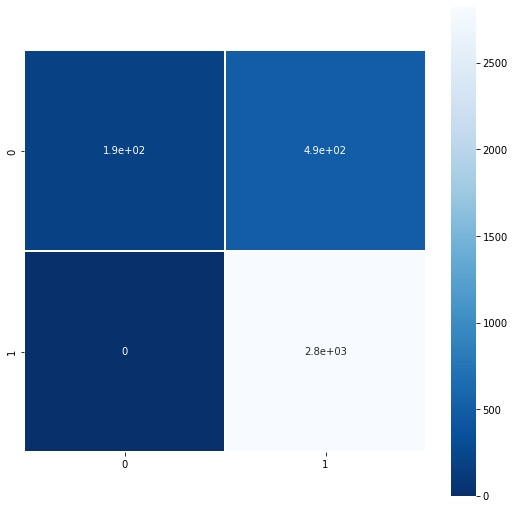

In [221]:
plt.figure(figsize = (9, 9))
plt.xlabel("Valor de predicción")
plt.ylabel("Valor de actual")
sns.heatmap(cnf_matrix, annot = True, linewidths = 0.5, square = True, cmap = "Blues_r")